In [1]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.spatial.distance import euclidean
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt
from zipfile import ZipFile

In [3]:
# Extract the ZIP file to a folder named Corel1k_MSD
zip_file_path = r'C:\Users\CODER\Downloads\Corel1k_MSD.zip'  # Replace with your actual path
extracted_folder = r'C:\Users\CODER\Downloads\Corel1k_MSD_images'
os.makedirs(extracted_folder, exist_ok=True)

# Extract the ZIP file
with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

In [4]:
# Function to load images from the extracted folder
def load_images_from_folder(folder_path, img_size=(128, 128)):
    images = []
    image_paths = glob(os.path.join(folder_path, '*'))
    for img_path in image_paths:
        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)
        images.append((img_path, img))
    return images

In [5]:
# Function to compute the MicroStructureDescriptor (MSD)
def compute_msd_descriptor(image):
    channels = cv2.split(image)
    msd = []
    for channel in channels:
        mean, std = cv2.meanStdDev(channel)
        msd.append(mean[0][0])  # Add mean
        msd.append(std[0][0])   # Add standard deviation
    return np.array(msd)

In [6]:
# Function to extract features using a pre-trained CNN (VGG16)
def extract_cnn_features(image):
    model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  # Changed input size to 224x224
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert image to RGB
    img = cv2.resize(img, (224, 224))  # Resize for VGG16 input
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = preprocess_input(img)  # Preprocess the image
    features = model.predict(img)  # Get features from VGG16
    features = features.flatten()  # Flatten the features into a vector
    return features

In [23]:
# Load images from the dataset folder
dataset_folder = r'C:\Users\CODER\Downloads\Corel1k_MSD_images'
images = load_images_from_folder(dataset_folder)

In [24]:
# Compute MSD and CNN features for all images
image_descriptors = []
for img_path, img in images:
    msd_descriptor = compute_msd_descriptor(img)
    cnn_features = extract_cnn_features(img)
    combined_features = np.concatenate((msd_descriptor, cnn_features))  # Concatenate MSD and CNN features
    image_descriptors.append((img_path, combined_features))

1/1 [==============================] - 0s 112ms/step


ResourceExhaustedError: {{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:AddV2]

In [9]:
import pickle

# Compute and save features
if not os.path.exists('image_features.pkl'):
    image_descriptors = []
    for img_path, img in images:
        msd_descriptor = compute_msd_descriptor(img)
        cnn_features = extract_cnn_features(img)
        combined_features = np.concatenate((msd_descriptor, cnn_features))
        image_descriptors.append((img_path, combined_features))

    # Save to a pickle file
    with open('image_features.pkl', 'wb') as f:
        pickle.dump(image_descriptors, f)
else:
    # Load precomputed features
    with open('image_features.pkl', 'rb') as f:
        image_descriptors = pickle.load(f)


In [10]:
# Function to calculate similarity using Euclidean distance
def calculate_similarity(query_descriptor, descriptors):
    similarities = []
    for img_path, descriptor in descriptors:
        distance = euclidean(query_descriptor, descriptor)
        similarities.append((img_path, distance))
    similarities.sort(key=lambda x: x[1])  # Sort by distance (lower is more similar)
    return similarities

In [12]:
# Allow user to input the path of the query image
query_image_path = r'C:\Users\CODER\Downloads\Corel1k_MSD_images\9.jpg'


# Read and process the query image
query_image = cv2.imread(query_image_path)
query_image = cv2.resize(query_image, (128, 128))  # Resize to match dataset images

In [13]:
# Compute MSD and CNN features for the query image
msd_descriptor = compute_msd_descriptor(query_image)
cnn_features = extract_cnn_features(query_image)
query_descriptor = np.concatenate((msd_descriptor, cnn_features))  # Combine the features

1/1 [==============================] - 8s 8s/step


In [14]:
# Calculate similarities
similar_images = calculate_similarity(query_descriptor, image_descriptors)

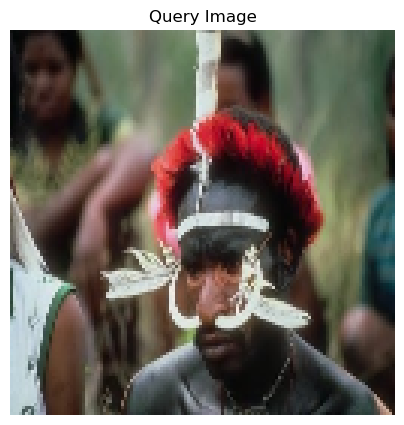

In [15]:
# Display the query image
plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB))
plt.title("Query Image")
plt.axis('off')
plt.show()

In [16]:
# Display top 5 most similar images
top_n = 5
for i, (img_path, distance) in enumerate(similar_images[:top_n]):
    similar_img = cv2.imread(img_path)
    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(similar_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Similar Image {i+1} - Distance: {distance:.2f}")
    plt.axis('off')
    plt.show()

In [17]:
def precision_at_k(query_descriptor, k=5):
    relevant_count = 0
    for img_path, descriptor in image_descriptors:
        if is_relevant(img_path):  # Assume a function `is_relevant`
            relevant_count += 1
    return relevant_count / k

# Placeholder for testing:
def is_relevant(img_path):
    return "expected_label" in img_path


In [22]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Assuming image_descriptors is defined
all_features = np.array([desc for _, desc in image_descriptors])
labels = [img_path for img_path, _ in image_descriptors]

# Check the number of samples
num_samples = all_features.shape[0]
print(f"Number of samples: {num_samples}")

# Set perplexity to a value less than the number of samples and ensure it's positive
perplexity_value = min(30, num_samples - 1)
print(f"Perplexity value: {perplexity_value}")

# t-SNE
tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=42)
features_2d = tsne.fit_transform(all_features)

# Plotting
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.title("Feature visualization: CNN + MSD")
plt.show()

Number of samples: 0
Perplexity value: -1


InvalidParameterError: The 'perplexity' parameter of TSNE must be a float in the range (0.0, inf). Got -1 instead.